In [42]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [43]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

x_valid, x_train = x_train[:20000], x_train[20000:] 

x_train = x_train.astype('float32') / 255.
x_valid = x_valid.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))
x_valid = np.reshape(x_valid, (len(x_valid), 32, 32, 3))
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))

noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.).astype('float32')
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.).astype('float32')
x_test_noisy = np.clip(x_test_noisy, 0., 1.).astype('float32')

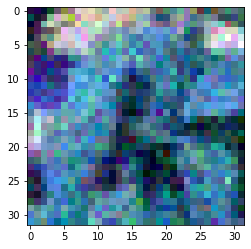

In [44]:
img = cv2.cvtColor(x_train[0], cv2.COLOR_BGR2RGB)
noisy_img = cv2.cvtColor(x_train_noisy[0], cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.imshow(noisy_img)

In [45]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs
		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)
		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")


		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
   
   # apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)
		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")
		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")
		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)
  

In [55]:
EPOCHS = 50
BS = 64

from tensorflow.keras.optimizers import Adam

(encoder, decoder, autoencoder) = ConvAutoencoder.build(32, 32, 3,(32,64),900)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt, metrics=["accuracy"])
print(autoencoder.summary())

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 900)               3707076   
_________________________________________________________________
decoder (Functional)         (None, 32, 32, 3)         3747139   
Total params: 7,454,215
Trainable params: 7,453,831
Non-trainable params: 384
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [56]:
# train the convolutional autoencoder
H = autoencoder.fit(
	x_train_noisy, x_train,
	validation_data=(x_valid_noisy, x_valid),
	epochs=EPOCHS,
	batch_size=BS)

Epoch 1/50
469/469 [==============================] - 7s 13ms/step - loss: 0.0114 - accuracy: 0.6760 - val_loss: 0.0079 - val_accuracy: 0.7120
Epoch 2/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0053 - accuracy: 0.7435 - val_loss: 0.0045 - val_accuracy: 0.7685
Epoch 3/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0045 - accuracy: 0.7559 - val_loss: 0.0042 - val_accuracy: 0.7692
Epoch 4/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0039 - accuracy: 0.7611 - val_loss: 0.0034 - val_accuracy: 0.7737
Epoch 5/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0036 - accuracy: 0.7652 - val_loss: 0.0031 - val_accuracy: 0.7955
Epoch 6/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0033 - accuracy: 0.7684 - val_loss: 0.0031 - val_accuracy: 0.7832
Epoch 7/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0032 - accuracy: 0.7712 - val_loss: 0.0029 - val_accuracy: 0.7834

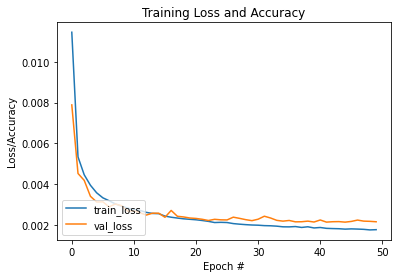

In [57]:
N = np.arange(0, EPOCHS)
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

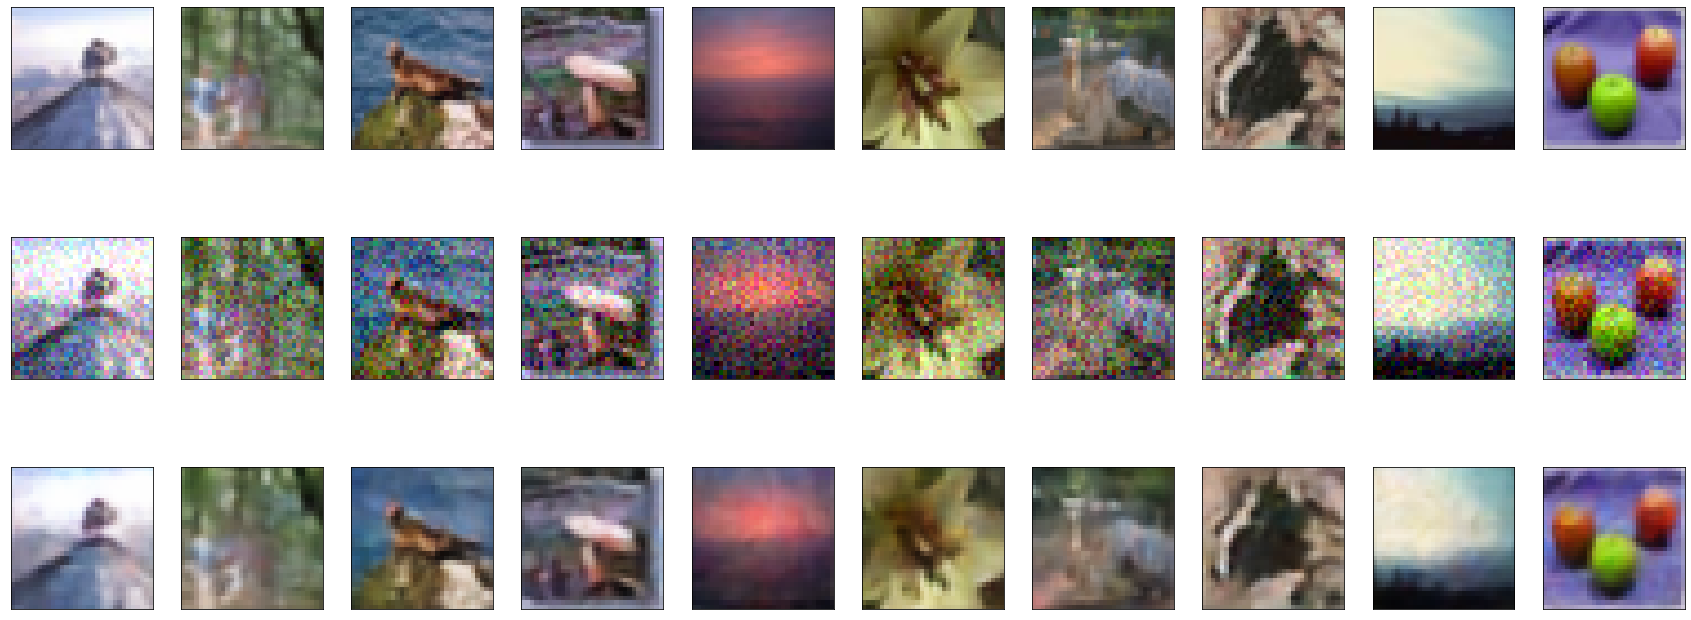

In [58]:
def plot_img(n, original_data, input_data, decoded_imgs):
  plt.figure(figsize=(30, 12))
  for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(original_data[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display original
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(input_data[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

decoded = autoencoder.predict(x_test_noisy)
plot_img(10,x_test,x_test_noisy,decoded)

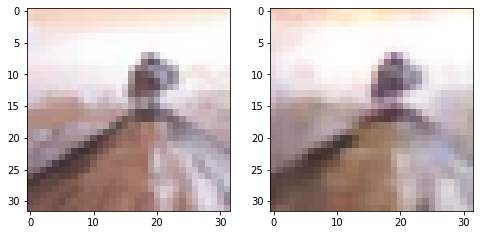

In [63]:
def plot_images(images):
  ''' 
  Plot input BGR images as RGB images
  
  Input: list 
    List of BGR images
  '''

  fig, ax = plt.subplots(nrows = 1, ncols = len(images), figsize = (4*len(images), 4*len(images)))
  for i, p in enumerate(images):
    ax[i].imshow(cv2.cvtColor(p, cv2.COLOR_BGR2RGB))
  plt.show()

decoded = autoencoder.predict(x_test_noisy)
plot_images([x_test[0],decoded[0]])

---
> **Results**
---
- Model (32, 32, 3,(32,64),512)

Performance: loss: 0.0020 - val_loss: 0.0024

- Model (32, 32, 3,(32,64),900)

Performance: loss: 0.0018 - val_loss: 0.0021